# GPU Programming Lab
This lab is an introduction of GPU programming with CUDA using python. It consists of 5 exercises plus homework. Write all your observations during the lab exercises and the homework in the report section at the bottom. Be brief and efficient. Send the report to Abdallah Alabdallah <abdallah.alabdallah@hh.se> by Friday, 1 May 2020 at 23:59.

# CUDA
CUDA is a parallel programming platform and an API that facilitates access to the CUDA-Enabled GPU functionality for general-purpose computing. It allows speeding up the software by utilizing the GPU power for the parallelizable part of the computation. Many Deep Learning platforms like TensorFlow, Keras, PyTorch and others rely on CUDA for their computations.

## Common CUDA terminology:
- <b>Host:</b> The CPU
- <b>Device:</b> The GPU
- <b>Host Memory:</b> The system main memory
- <b>Device Memory:</b> The GPU onboard memory
- <b>kernel:</b> A function that runs on the Device

In CUDA threads are organized into a grid of blocks, where each block contains a subset of the threads that can cooperate using a block shared memory and can synchronize within each block.
<img src='https://github.com/FredrikM97/BDPP-Labs/blob/master/Labs/Lab4-GPU/files/grid1.png?raw=1' width="50%" height="50%"></img>


Parallel portions of an application are executed on the device (GPU) as kernels, where an array of threads executes each kernel. Each thread has an ID, by which it controls the portion of the data to execute the kernel. All threads run the same code on different portions of the data. Grids and blocks can be organized as 1D, 2D, or 3D arrays. 

<img src='https://github.com/FredrikM97/BDPP-Labs/blob/master/Labs/Lab4-GPU/files/grid2.png?raw=1' width="50%" height="50%"></img>


# Numba
CUDA is designed to work with C++, but in this Lab, we will work with Numba; a Python JIT compiler that translates subsets of the code into machine code, and enables writing parallel GPU algorithms in Python

## Numba installation


conda install numba

pip install numba

# Kernel 
- A Kernel is declared as a function with @cuda.jit decorator.
- A Kernel function cannot have a return value and manages outputs as input-output arrays

In [0]:
from numba import cuda

# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # code here
    pass


To invoke a kernel, you have to specify the number of blocks in the grid, and the number of threads per block. This can be done by specifying the number of threads per block and calculating how many blocks are required in the grid based on the size of the data.

Note: In the case that the data size is not divisible by the number of thread per block, we take the ceiling of the number to reserve an extra block for the remaining part of the data. So the threads in the last block will not be fully occupied.


In [0]:
import numpy as np
import math

# kernel invocation
data = np.ones(256)

threadsperblock = 32
blockspergrid = math.ceil(len(data)/threadsperblock)

my_kernel[blockspergrid, threadsperblock](data)


# Exercise 1: Element-wise operation

The following kernel takes a 1D array as input and computes the element-wise cube-root x^(1/3) for each element in the array. This an example of a simple mathematical operation that is, nevertheless, somewhat costly computationally. If you are interested in delving more in-depth, you can replace it with a more straightforward operation, like multiplication, and see what happens.

- pos: holds the position in the data on which the thread will work.
- always check that the position does not exceed the length of the data, for the cases when the data length is not devisable by the number of threads per block.

<img src='https://github.com/FredrikM97/BDPP-Labs/blob/master/Labs/Lab4-GPU/files/pos1.png?raw=1' width="50%" height="50%"></img>

Read the code below and compute the position on which each thread will do its computation in the output array.

In [3]:
from numba import cuda
import numba as nb
import numpy
import math

# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    # Compute flattened index inside the array
    #TODO: compute the correct pos value based on the tread index and the block index and the block width
    pos = 0
    pos = bx*bw+tx
    #pos = cuda.grid(1) # this function returns the same value for the position in a 1D grid
    if pos < io_array.size:
        io_array[pos] = io_array[pos]**(1/3)
        

# kernel invocation
data = numpy.ones(2048)
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)
print(data)

[1. 1. 1. ... 1. 1. 1.]


### Comparison between this kernel and Numpy
Try different array sizes and compare computation time between CPU (using numpy) and GPU.
Is there a relation between the size of the array and difference in performance? Explain what you notice.

In [4]:
data = numpy.ones(10000000)
%timeit np.cbrt(data)


1 loop, best of 3: 197 ms per loop


In [5]:
data = np.ones(10000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)


10 loops, best of 3: 42.3 ms per loop


## Exercise 2: Matrix Multiplication

In matrix multiplication, every kernel is reponsible for computing one element of the output matrix. It reads one row from the first matrix (A) and one column form the second matrix (B) and computes the dot product of these two vectors and places it in the corresponding cell in the output matrix (C), as shown in the following figure.

<img src='https://github.com/FredrikM97/BDPP-Labs/blob/master/Labs/Lab4-GPU/files/matmul.png?raw=1' width="50%" height="50%"></img>

Write a kernel to do the multiplication of two matrices.

In [0]:
# CUDA kernel
@cuda.jit
def mat_mul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    
    # find the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    
    if row < C.shape[0] and col < C.shape[1]:
        #TODO: Compute the dot product "prod" of the corresponding vectors of this position 
        prod = 0
        for k in range(A.shape[1]):
            prod += A[row, k] * B[k, col]
        C[row, col] = prod


## Exercise 3: Create a host function to invoke the kernel

It is a good practice to manually copy the matrices to the device (the GPU memory) using "cuda.to_device" to reduce the unnecessary data transfer between the device and the host.

To test the kernel "mat_mul" we prepare the host function "gpu_dot" which will take two matrices as parameters and returns the output matrix. The job of this host function is to prepare the data and to invoke the kernel.

Read the code below and calculate how many blocks are required to start the kernel. Use the calculated values to invoke the kernel.

In [7]:
# Input Test arrays
A = np.full((1024, 512), 3, np.float32) # matrix containing all 3's
B = np.full((512, 2048), 4, np.float32) # matrix containing all 4's

def gpu_dot(A, B):
    #Copy the input matrices to the gpu
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B) # this value should be changed 

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]), dtype=np.float64) # replace "None" with the correct type

    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (32, 32)
    
    #TODO: Calculate how many blocks are required
    blockspergrid_x = math.ceil(A.shape[0]/threadsperblock[0]) # this value should be changed 
    blockspergrid_y =  math.ceil(B.shape[1]/threadsperblock[1]) # this value should be changed
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    #TODO: Start the kernel based on the calculated grid
    mat_mul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
    
    # Copy the result back to the host
    C = C_global_mem.copy_to_host()
    return C


#Test the host function
gpu_dot(A,B)

array([[6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       ...,
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.]])

### Testing the calculations time compared to numpy

In [8]:
%timeit gpu_dot(A,B)

10 loops, best of 3: 72.4 ms per loop


In [9]:
%timeit np.dot(A,B)

10 loops, best of 3: 26.1 ms per loop


## Exercise 4: Distance Matrix
The distance matrix (D) of a data matrix (A) is the matrix that contains the eucleadian distance between each two row vectors as shown in the following figure.
<img src='https://github.com/FredrikM97/BDPP-Labs/blob/master/Labs/Lab4-GPU/files/distmat.png?raw=1' width="50%" height="50%"></img>

where 
$$D[i,j]=D[j,i]=dist(A[i,:], A[j,:])$$


Use what you have learned in the previous exercises to write a kernel and a host function to compute the distance matrix of a given data matrix.

In [10]:
import numpy as np
from numba import cuda

@cuda.jit("void(float64[:, :], float64[:, :])")
def distance_matrix(mat, out):
    #TODO: write a kernel to compute the distance matrix of the input "mat" and place the result in "out"
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
  
    if i < m and j < m:
      d = 0
      for k in range(n):
          tmp = mat[i, k] - mat[j, k]
          d += tmp * tmp
      out[i, j] = d


def gpu_dist_matrix(mat):
    #TODO: write a host function to calculate the grid size and use the calculated values to invoke the "distance_Matrix" kernel

    rows = mat.shape[0]
    block_dim = (16, 16)
    grid_dim = (rows//block_dim[0] + 1, rows//block_dim[1] + 1)

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np.float64), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)
    return out


A = np.random.randn(1024,1024)
D = gpu_dist_matrix(A)
print(D)

[[   0.         2071.57090912 2031.60629317 ... 1999.51930259
  2036.17782234 1954.03913538]
 [2071.57090912    0.         2126.57894696 ... 2087.8616115
  2090.86409979 1903.02766198]
 [2031.60629317 2126.57894696    0.         ... 2156.09429417
  2099.04614647 1942.22011836]
 ...
 [1999.51930259 2087.8616115  2156.09429417 ...    0.
  2100.3439095  2047.18282298]
 [2036.17782234 2090.86409979 2099.04614647 ... 2100.3439095
     0.         1977.69297631]
 [1954.03913538 1903.02766198 1942.22011836 ... 2047.18282298
  1977.69297631    0.        ]]


# Exercise 5: Convolution

Write a convolution kernel and host function that convolves a grayscale image with a filter and compare the performance with the convolution method in scipy "scipy.ndimage.filters.convolve".

<img src='https://github.com/FredrikM97/BDPP-Labs/blob/master/Labs/Lab4-GPU/files/conv.png?raw=1' width="50%" height="50%"></img>

In [0]:
@cuda.jit
def conv_kernel(image, cfilter, out_image):
    # TODO: write a kernel to convolve the image with the filter and produce a the filtered image out_image 
    M, N = image.shape
    Mf, Nf = cfilter.shape
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    for i in range(Mf2, M - Mf2):
        for j in range(Nf2, N - Nf2):
            num = 0.0
            for ii in range(Mf):
                for jj in range(Nf):
                    num += (cfilter[Mf-1-ii, Nf-1-jj] * image[i-Mf2+ii, j-Nf2+jj])
            out_image[i, j] = num
    
def gpu_conv(image, cfilter):
    # write a host function to invoke the kernel conv_kernel
    rows = image.shape[0]
    block_dim = (16, 16)
    grid_dim = (rows//block_dim[0] + 1, rows//block_dim[1] + 1)

    stream = cuda.stream()
    image1 = cuda.to_device(np.asarray(image, dtype=np.float64), stream=stream)
    image2 = cuda.to_device(np.asarray(cfilter, dtype=np.float64), stream=stream)
    out2 = cuda.device_array((rows, rows))
    conv_kernel[grid_dim, block_dim](image1, image2, out2)
    out_image = out2.copy_to_host(stream=stream)

    return out_image

## Testing the convolution kernel

Image Shape: (256, 256)
Filter:
 [[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]
1 loop, best of 3: 1.46 s per loop


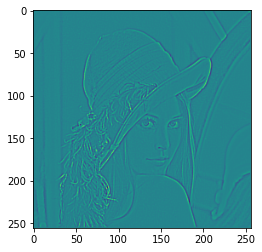

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

#Loading the image and converting it to numpy array
im = Image.open("/content/QCaSg.png")
im_arr = np.array(im.getdata()).reshape(im.size[0], im.size[1])
plt.imshow(im_arr, cmap='gray')
print("Image Shape:",im_arr.shape)

# Creating the filter to use
filt = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
print("Filter:\n",filt)
%timeit img = gpu_conv(im_arr, filt)
plt.imshow(img)

1000 loops, best of 3: 1.69 ms per loop


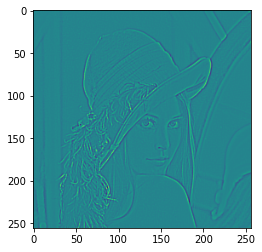

In [17]:
from scipy.ndimage.filters import convolve

# Using scipy convolution
%timeit filtered_image = convolve(im_arr, filt)

plt.imshow(filtered_image)

# Homework: Development of a Simple Neural Network

The purpose of using GPUs for training in deep learning is its ability to parallelize matrix computation on which deep learning models heavily rely. 

For the purpose of this Lab, we will use the file NN.py, which contains an MLP class used to create a multi-layer neural network. The class MLP accepts as input the network structure (as a dictionary object), and a matrix multiplication function to use in the computations. By default, the matrix multiplication function it uses is "numpy.dot". We can try the function implemented in Example 2 and compare it with NumPy.

Read the file NN.py, and implement the missing parts (places marked with TODO keywords). The file is a full implementation of the neural network that consists of feedforward and backpropagation for training the neural networks. The backward calculations involve the computation of the gradients of the loss function with respect to the weights of the network dL/dw. This part is implemented, but you are encouraged to read it carefully to understand how it is calculated.

Most of the parts that you are required to calculate are in the feedforward step. Read the comments carefully to be able to know the kind of output that is expected from each method.

After completing the code in NN.py file, use the code below to verify that it is working. Use the matrix multiplication function that you have developed earlier and compare it with the use of Numpy multiplication. Explain what you notice.

Write a short report in the section below, explaining your observations. Send the report to Abdallah Alabdallah <abdallah.alabdallah@hh.se> by Friday, 1 May 2020 at 23:59.


In [14]:
from NN import MLP
import numpy as np

NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

# matmul holds the function to be used for matrix multiplication, it can be np.dot or gpu_dot
model = MLP(NN_ARCHITECTURE, matmul=gpu_dot) 

ModuleNotFoundError: ignored

In [0]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1


# Create the Data
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Training
model.train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), 10000, 0.01, verbose=True)
# Prediction
Y_test_hat = model.predict(np.transpose(X_test))

# Accuracy achieved on the test set
acc_test = model.get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

In [0]:
%timeit gpu_dist_matrix(A)

In [0]:
%timeit gpu_dot(A,A)

In [0]:
%timeit np.dot(A,A)

# Report:
Send the report to Abdallah Alabdallah <abdallah.alabdallah@hh.se> by Friday, 1 May 2020 at 23:59.

### Name: Fredrik Mårtensson

### Exercise 1:
Numpy performs better on small sets but the GPU performces a lot more efficient on the bigger sets.
### Exercise 2:
Applying @ (dot product) seems to be working
### Exercise 3:
array([[6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       ...,
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.],
       [6144., 6144., 6144., ..., 6144., 6144., 6144.]])

### Exercise 4:
100 loops, best of 3: 4.72 ms per loop
10 loops, best of 3: 30 ms per loop

[[   0.         2002.38547125 2124.75705019 ... 2125.89323224
  1917.64544375 1947.99866243]
 [2002.38547125    0.         2083.13335267 ... 2197.89610329
  2078.17913804 2105.57446887]
 [2124.75705019 2083.13335267    0.         ... 2215.08246739
  1965.34088316 2023.09916957]
 ...
 [2125.89323224 2197.89610329 2215.08246739 ...    0.
  2088.12208884 2087.82017226]
 [1917.64544375 2078.17913804 1965.34088316 ... 2088.12208884
     0.         2089.73793962]
 [1947.99866243 2105.57446887 2023.09916957 ... 2087.82017226
  2089.73793962    0.        ]]

### Exercise 5:
1 loop, best of 3: 1.46 s per loop
1000 loops, best of 3: 1.69 ms per loop
### Homework: